https://medium.com/tokopedia-data/step-by-step-text-classification-fa439608e79e

In [2]:
import pandas as pd
df = pd.read_csv('/Users/sdeshpande/Desktop/text_analysis_scripts/uci-news-aggregator.csv')
df.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


# Data cleaning

In [3]:
# — b : business — t : science and technology — e : entertainment — m : health
category_name = pd.DataFrame({'id' : ['b','t','e','m'], 'cat_name' : ['business','science and technology', 'entertainment', 'health']})
df = df[['TITLE', 'CATEGORY']]
df = pd.merge(df,category_name,left_on = 'CATEGORY',right_on = 'id')[['TITLE','cat_name']]

In [4]:
df.head()

,TITLE,cat_name
0,"Fed official says weak data caused by weather,...",business
1,Fed's Charles Plosser sees high bar for change...,business
2,US open: Stocks fall after Fed official hints ...,business
3,"Fed risks falling 'behind the curve', Charles ...",business
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,business


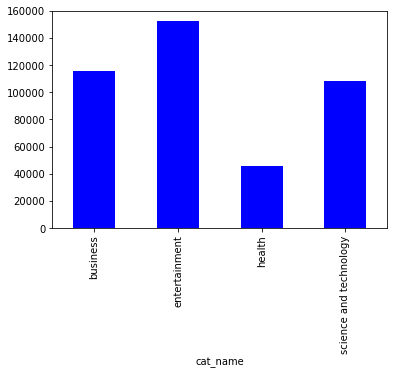

In [5]:
df.groupby('cat_name').TITLE.count().plot.bar(color = 'blue')

In [7]:
import re
def remove_punc(sentence):
    sentence = sentence.lower()
    sentence = re.sub('[^a-z]+', ' ', sentence)
    return sentence

In [8]:
df["TITLE"] = df["TITLE"].apply(lambda x: remove_punc(x))
df.head()

,TITLE,cat_name
0,fed official says weak data caused by weather ...,business
1,fed s charles plosser sees high bar for change...,business
2,us open stocks fall after fed official hints a...,business
3,fed risks falling behind the curve charles plo...,business
4,fed s plosser nasty weather has curbed job growth,business


In [9]:
from nltk.corpus import stopwords
sw = stopwords.words("English")
def stop_word(sentence):
    new_sentence = []
    for word in sentence.split():
        if word not in sw:
            new_sentence.append(word)
    return(" ".join(new_sentence))
df["TITLE"] = df["TITLE"].apply(stop_word)
df.head()

,TITLE,cat_name
0,fed official says weak data caused weather slo...,business
1,fed charles plosser sees high bar change pace ...,business
2,us open stocks fall fed official hints acceler...,business
3,fed risks falling behind curve charles plosser...,business
4,fed plosser nasty weather curbed job growth,business


use Lemmatization instead of stemming. Unlike stemming, which keeps reducing words until reaching it ‘stem’, lemmatization depends on correctly identifying the intended part of speech and its meaning.

In [10]:
# from nltk.stem.snowball import SnowballStemmer
# stemmer = SnowballStemmer('english')
# def stem(sentence):
#     new_sentence = []
#     for word in sentence.split():
#         word = stemmer.stem(word)
#         new_sentence.append(word)
#     return(" ".join(new_sentence))
# df['TITLE'] = df['TITLE'].apply(stem)
# df.head()

In [11]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize(sentence):
    new_sentence = []
    for word in sentence.split():
        word = lemmatizer.lemmatize(word)
        new_sentence.append(word)
    return(" ".join(new_sentence))
df['TITLE'] = df['TITLE'].apply(lemmatize)
df.head()

,TITLE,cat_name
0,fed official say weak data caused weather slow...,business
1,fed charles plosser see high bar change pace t...,business
2,u open stock fall fed official hint accelerate...,business
3,fed risk falling behind curve charles plosser say,business
4,fed plosser nasty weather curbed job growth,business


# Feature extraction

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
Tfidf = TfidfVectorizer(min_df=5, ngram_range=(1, 2))
tfidf_features = Tfidf.fit_transform(df.TITLE)
tfidf_features.shape

(422419, 97542)

In [14]:
from sklearn.feature_selection import chi2
import numpy as np
N = 5
Number = 1
for category in df['cat_name'].unique():
    features_chi2 = chi2(tfidf_features, df['cat_name'] == category)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(Tfidf.get_feature_names())[indices]
    unigrams = [x for x in feature_names if len(x.split(' ')) == 1]
    bigrams = [x for x in feature_names if len(x.split(' ')) == 2]
    print("{}. {} :".format(Number,category))
    print("\t# Unigrams :\n\t. {}".format('\n\t. '.join(unigrams[-N:])))
    print("\t# Bigrams :\n\t. {}".format('\n\t. '.join(bigrams[-N:])))
    Number += 1

1. business :
	# Unigrams :
	. profit
	. market
	. rate
	. bank
	. stock
	# Bigrams :
	. mortgage rate
	. unemployment rate
	. interest rate
	. home sale
	. wall street
2. science and technology :
	# Unigrams :
	. facebook
	. microsoft
	. samsung
	. apple
	. google
	# Bigrams :
	. climate change
	. htc one
	. xbox one
	. google glass
	. samsung galaxy
3. entertainment :
	# Unigrams :
	. season
	. movie
	. kim
	. star
	. kardashian
	# Bigrams :
	. justin bieber
	. kanye west
	. miley cyrus
	. game throne
	. kim kardashian
4. health :
	# Unigrams :
	. outbreak
	. study
	. mers
	. cancer
	. ebola
	# Bigrams :
	. breast cancer
	. ebola virus
	. west africa
	. west nile
	. ebola outbreak


# Decision tree

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
DTClass = DecisionTreeClassifier(criterion="gini", splitter="best", random_state=77)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, df['cat_name'], test_size = 1/5, random_state = 50)
DTClass.fit(X_train,y_train)
prediction = DTClass.predict(X_test)
from sklearn.metrics import accuracy_score
print("accuracy score:")
print(accuracy_score(y_test, prediction))

accuracy score:
0.9134510676577814


# SVC

In [17]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
svc = LinearSVC()
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, df['cat_name'], test_size = 1/5, random_state = 50)
svc.fit(X_train,y_train)
prediction = svc.predict(X_test)
print("accuracy score:")
print(accuracy_score(y_test, prediction))

accuracy score:
0.9575067468396383


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
RFClass = RandomForestClassifier(n_estimators=500, criterion="gini", random_state=77)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, df['cat_name'], test_size = 1/5, random_state = 50)
RFClass.fit(X_train,y_train)
prediction = RFClass.predict(X_test)
print("accuracy score:")
print(accuracy_score(y_test, prediction))

# Stochiastic Gradient Descent

In [ ]:
from sklearn.linear_model import SGDClassifier
SGDC = SGDClassifier()
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, df['cat_id'], test_size = 1/5, random_state = 50)
SGDC.fit(X_train, y_train)
prediction = SGDC.predict(X_test)
print("accuracy score:")
print(accuracy_score(y_test, prediction))